# Tia Openess Demo 2 - Quinten Bauwens

In this notebook is used as a test environment for testing features before implementing them in the main program.

Software used:
 - Windows 10
 - Visual Studio Code
 - Python 3.11.4
 - TIA Portal 15.1:
    -  SIMATIC STEP 7 Professional - WinCC Professional v15.1 Upd5
    -  SIMATIC Step 7 Safety v15.1
    -  SIMATIC Visualization Architect v15.1
    -  SINAMICS Startdrive V15.1
    -  Tia Openess Explorer (hardly advised, this will help you understand the available attributes of each object!)

Versions of the Python-packages can be found in the requirements.txt file

## 1. Initializing TIA project

In [1]:
import os
import sys
import clr
clr.AddReference("C:\\Program Files\\Siemens\\Automation\\Portal V15_1\\PublicAPI\\V15.1\\Siemens.Engineering.dll")
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)

# Assuming the notebook is in the 'docs' directory and you want to add 'src' to the path
# Adjust the path as necessary based on your notebook's location
project_root = os.path.abspath(os.path.join(current_dir, '..', 'src'))

sys.path.append(project_root)

c:\Users\QBAUWENS\Documents\Openess\docs


In [2]:
from utils import InitTia as Init
# Needed modules: InitTiaProject, json 
# Open the project
myproject, myinterface = Init.open_project(False, "C:\Temp\P712713A01\P712713A01.ap15_1")
#C:\Program Files\Siemens\Automation\Portal V15_1\PublicAPI\V15.1\Siemens.Engineering.dll
#C:\Temp\P712713A01\P712713A01.ap15_1

In [3]:
import json
import Siemens.Engineering as tia # Copy the Siemens.Engineering.dll to the folder of the script (current working dir.)!!
import Siemens.Engineering.HW.Features as hwf # Import the HW Features, to locate the software container
from collections import OrderedDict as od
import os
import pandas as pd

## 2. Project information

In [16]:
print('Project Information')
print(f'''
        Name: \t\t\t {myproject.Name}
        Creation time:\t\t {myproject.CreationTime}
        Last Change:\t\t {myproject.LastModified}
        Author:\t\t\t {myproject.Author}
        Last modified by:\t {myproject.LastModifiedBy}
    ''')

print('Project History')
print(f'''
        DateTime\t\t Event\t\t''')
for event in myproject.HistoryEntries:
    print('\t',event.DateTime, '\t',event.Text)


Project Information

        Name: 			 P712713A01
        Creation time:		 19/02/2018 12:30:58
        Last Change:		 9/09/2024 11:51:16
        Author:			 Imtech
        Last modified by:	 QBAUWEN1
    
Project History

        DateTime		 Event		
	 19/02/2018 12:40:55 	 Migration from STEP 7 K5.5.4.0, WinCC V7.4 to V14 SP1
	 19/02/2018 15:00:47 	 Created by user in version CPU 319F-3 PN/DP PLC migration
	 23/02/2018 14:29:31 	 Mass data import
	 23/02/2018 14:30:25 	 Mass data import
	 23/02/2018 14:31:41 	 Mass data import
	 23/02/2018 14:33:44 	 Mass data import
	 23/02/2018 15:34:40 	 Mass data import
	 1/03/2018 13:12:21 	 Mass data import
	 2/03/2018 12:11:27 	 The project was updated from project library.
	 2/03/2018 12:17:01 	 The project was updated from project library.
	 2/03/2018 12:36:59 	 Mass data import
	 2/03/2018 13:04:02 	 Mass data import
	 2/03/2018 13:25:29 	 Mass data import
	 2/03/2018 13:26:20 	 Mass data import
	 14/03/2018 13:55:30 	 Mass data import
	 14/03/

In [4]:
# Needed modules: Siemens.Engineering.HW.Features
# Get all the hardware 
def give_items(device, Items=[]):
    for item in device.DeviceItems:
        Items.append(item)
        Items = give_items(item, Items)
    return Items

def get_devices(group, Items=[]):
    '''
    Returns all the devices of a group.
    '''
    for device in group.Devices:
        Items = give_items(device, Items)
    return Items

def get_interface_devices(projectItems, Items=None):
    '''
    Returns all the devices with an interface-service.
    '''
    if Items is None:
        Items = []
    for deviceitem in projectItems:  # for all the devices and deviceItems in the project
        network_service = tia.IEngineeringServiceProvider(deviceitem).GetService[hwf.NetworkInterface]()  # get the interface service
        if isinstance(network_service, hwf.NetworkInterface):  # check whether the service does exist
            Items.append(deviceitem)
    return Items

def get_plc_devices(projectItems, Items=None):
		'''
		Returns all the devices with a plc-service.
		'''
		if Items is None:
				Items = []
		for deviceitem in projectItems:  # for all the devices and deviceItems in the project
				if str(deviceitem.Classification) == 'CPU':  # filter out the plc devices
						Items.append(deviceitem)
		return Items
    
def get_groups(group_composition, Items=[]):
    '''
    Returns all the groups and devices of a group-composition. 
    '''
    for group in group_composition:
        Items = get_devices(group, Items)
        Items = get_groups(group.Groups, Items)
    return Items

def GetAllItems(myproject):
    '''
    Returns a list of all the DeviceItems such as plc's, interfaces, ports, ...
    Does not include the stations. 
    '''

    Items = []
    Items.extend(get_devices(myproject))
    Items.extend(get_devices(myproject.UngroupedDevicesGroup))
    Items.extend(get_groups(myproject.DeviceGroups))
    Items = list(set(Items)) # removes all the duplicates
    return Items

projectItems = GetAllItems(myproject) # a list of all the devices and deviceItems
interfaceDevices = get_interface_devices(projectItems)

#for item in interfaceDevices: # TEST
#    print(item.Name)

In [5]:
PLC_List = get_plc_devices(projectItems) # a list of all the plc's

print('PLC Information\n')
print(f'{"Name":<20}{"Ordernummer":<20}') # :<20 is a formatting option that makes sure the string is at least 20 characters long
for PLC in PLC_List:
    print(f'{PLC.Name:<20}{PLC.TypeIdentifier[12:]:<20}') # TypeIdentifier is a string that contains the ordernumber of the PLC

PLC Information

Name                Ordernummer         
P209000AE01-JC5     6ES7 517-3FP00-0AB0/V2.6


### 2.1 Retrieve PLC software

Tia Openes explorer:

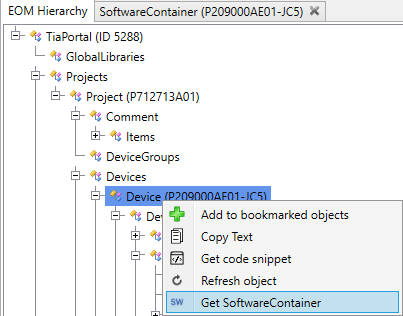

In [6]:
# needed modules: Siemens.Engineering, Siemens.Engineering.HW.Features
software_container = PLC_List[0].GetService[hwf.SoftwareContainer]() # Get the plc software of the first plc in the list - equivalent of the gui picture above
plc_software = software_container.Software # Get the software of the plc out of the software container

print(plc_software.Name) # Print the name of the software and the parent of the software

P209000AE01-JC5


In [7]:
'''
retrieving every program block in the plc, and linking it to the group it is in
find method to find the location of a certain program-block in the plc
'''

def get_blocks(group, blocks=None, group_included=True):
	"""
	Recursive function to get all the blocks in the group.

	Parameters:
	- group: The group object to retrieve blocks from.
	- blocks: (Optional) The initial blocks object to store the blocks. Defaults to None.
	- option: (Optional) The option to specify the type of blocks object. Defaults to 'dict'.

	Returns:
	- blocks: The blocks object containing all the blocks in the group.
	"""
	if blocks is None:
		blocks = {} if group_included else []

	if not group_included:
		blocks.extend([block for block in group.Blocks])
		for sub_group in group.Groups:
			get_blocks(sub_group, blocks, group_included=False)
		return blocks
	
	try:
		if group not in blocks:
			# if group contains blocks -> add them as a list to the dict, else add an empty list
			blocks[group] = ([block for block in group.Blocks] if hasattr(group, 'Blocks') else [])
			# if group contains a subgroup (.Groups) -> add the group as a dict inside the list of blocks, wich then contains the subgroup and its blocks
			if hasattr(group, 'Groups'):
				for sub_group in group.Groups:
					sub_blocks = get_blocks(sub_group)
					blocks[group].append({sub_group: sub_blocks[sub_group]})
	except Exception as e:
		print(f'Failed to retrieve software blocks with its group: {str(e)}')
	return blocks

def list_blocks(blocks):
		for group_name, block_name in blocks.items():
				print(group_name.Name)
				for block in block_name:
						print('\t', block.Name)

def get_block(group, block_name): # Function to get a block by name
		blocks = get_blocks(group)
		for blockgroup in blocks:
			for block in blocks[blockgroup]:
				if block.Name.upper() == block_name.upper():
						return block

def find_block_group(block_name):
		blocks_dict = get_blocks(plc_software.BlockGroup)
		for group, block_list in blocks_dict.items():
				for block in block_list:
						if block.Name == block_name:
								return block

blocks_dict = get_blocks(plc_software.BlockGroup)
list_blocks(blocks_dict)

block_to_find = 'F209220ZS01Output'
location = find_block_group(block_to_find)
print(f'\nblocklocation of {block_to_find} in tia : {location.Parent.Parent.GetAttribute("Name")}\\{location.Parent.GetAttribute("Name")}\\{location.Name}\\{block_to_find}') # optimaliseren manier om de locatie van een block te vinden

Program blocks
	 Changes


AttributeError: 'dict' object has no attribute 'Name'

## 3. Network Parameters - Ethernet addresses
Documentation:
- https://support.industry.siemens.com/forum/be/en/posts/accessing-nodes-openness/255511
    
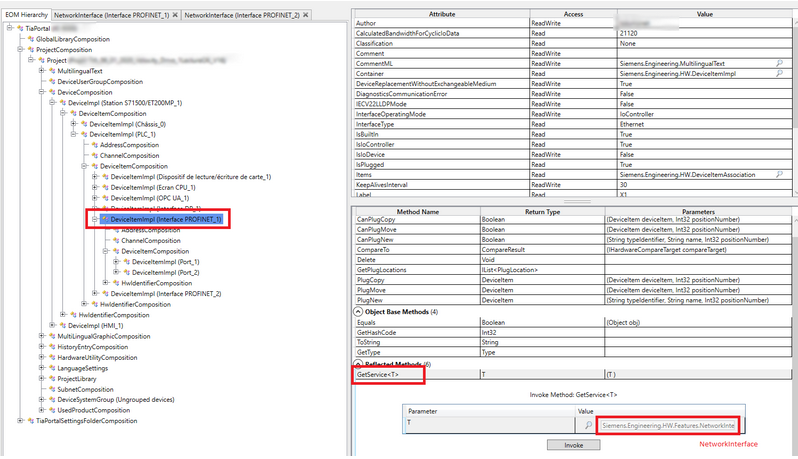

### Finding attributes with the corresponding service of device, for example NetworkInterface:

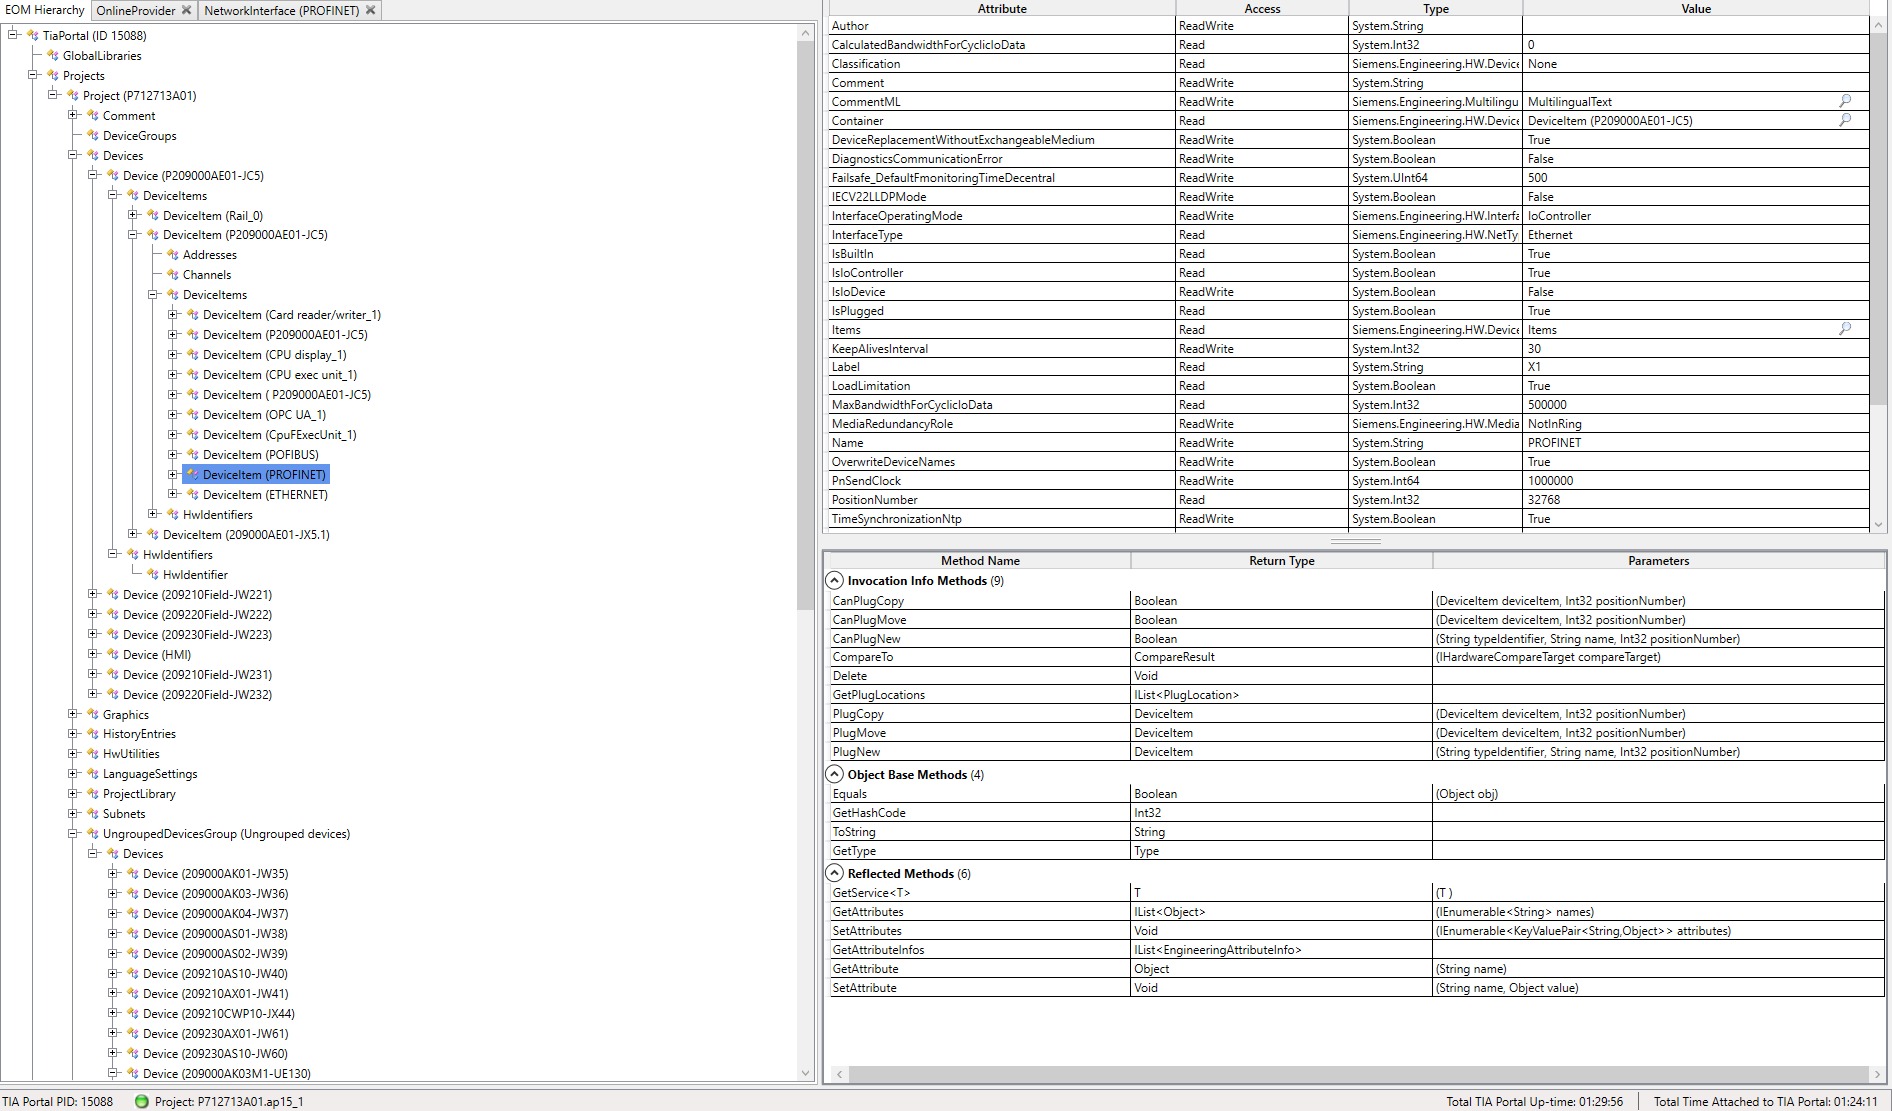

Execute the code below to find all devices with networkinterface

if you lookup a name ex. "PROFINET" in openess explore and use the GetService methode for network interface u'll see all the corresponding attributes

In [ ]:
# Import the HW Features
import Siemens.Engineering.HW.Features as hwf 

interface_devices = []

for deviceitem in projectItems: # for all the devices and deviceItems in the project
    network_service = tia.IEngineeringServiceProvider(deviceitem).GetService[hwf.NetworkInterface]() # get the interface service
    if type(network_service) == hwf.NetworkInterface: # check wether the service do excist
        interface_devices.append(deviceitem)
        print(network_service.GetAttribute('Name')) # print the name of all the items with an interface-service

209210AS10-JW40
209000AE02-JW208.X2
209210AX02-JW43
209000AK04M1-UE140
209210AS20-JW48
209220CWP10-JX55
209210AS11-JW42
209210CWP10-JX44
209000AE02-JW208.X1
ETHERNET
209220AX01-JW51
PROFINET interface
211212AE1-JW200
209210AX01-JW41
209230AX01-JW61
209000AE01-JC31
POFIBUS
209220CWP10-JX57
209000AK01-JW35
209230CHB22M14-UE152
209000AK04M4-UE142
209000AS01-JW38
209220Field-JW222
209000AE02-JW210
209000AE02-JW71
209210CWP20-JX47
209000AK01E1-BE30
209230CR22M1-UE153
209220AS10-JW50
209000AE02-JW211
209000AK04M4-UE141
209220AS11-JW52
209210Field-JW221
209220CWP10-JX54
209220AS20-JW58
209000AK03-JW36
209000AK03M4-UE131
209230Field-JW223
209220Field-JW232
209220CHB21M14-UE144
209230CA21M4-UE150
209210CWP20-JX46
209210CHB21M14-UE134
209000AK03M4-UE132
209000AE02-JW70
209000AK04M1-UE143
209000AK03M1-UE130
209230ASD01-JW190
209210CWP10-JX45
PROFINET
209000AK03M1-UE133
209230AS10-JW60
209220CWP20-JX56
209000AK02-JC32
209210Field-JW231
209220AX02-JW53
209000AS02-JW39
209000AK04-JW37
209230CHB21M14

Idee schetsen van hoe de Profinet data eruit zou moeten zien
```python
n_interfaces = {
	"plc_name": {
		"subnetmask": '',
		"gateway": '',
		"devices": [
			{
				'device_name': [
					{
						"nodes": {
							'node_name': 'ip_value'
						}
					}
				]
			}
		]
	}
}
```

In [ ]:
# TODO : NEEDS TO BE UPDATED AS NEXT NETWORK TROUGH SUBNETS THERE IS MORE THAN 1 NETWORK

# Needed modules : collections ordereddict
def getNodeList(items={}):
	'''
	gives a dictionary with all the plc's and their network information with the connected devices and their nodes
	'''
	PLC_List = get_plc_devices(projectItems)

	for plc in PLC_List:
		this_plc_name = plc.Name
		items[this_plc_name] = od()
		items[this_plc_name]["Network"] = {} # Initialize an empty "Network" key to ensure it's the first key
		items[this_plc_name]["devices"] = []

		this_plc_dict = items[this_plc_name]
		devices_list = this_plc_dict["devices"]

		for device in interface_devices:
			network_service = tia.IEngineeringServiceProvider(device).GetService[hwf.NetworkInterface]()

			if not isinstance(network_service, hwf.NetworkInterface): # skip the device if it does not have a network interface
				continue
					
			this_device_name = device.Name
			this_device_list = []

			if (device.Name == "PROFINET"):
				this_plc_subnet = network_service.Nodes[0].GetAttribute("SubnetMask")
				this_plc_gateway = network_service.Nodes[0].GetAttribute("RouterAddress")

				items[this_plc_name]["Network"] = { # update the network key with values
				"subnetmask" : this_plc_subnet,
				"gateway" : this_plc_gateway
				}

			this_nodes_dict = {}
			
			for index in range(network_service.Nodes.Count):
					this_node_name = network_service.Nodes[index].GetAttribute("Name")
					this_node_address = network_service.Nodes[index].GetAttribute("Address")

					this_nodes_dict[this_node_name] = this_node_address # add node to the dictionary
			
			this_device_list.append({"nodes" : this_nodes_dict}) # bundle all the nodes in the corresponding device	
			devices_list.append({this_device_name : this_device_list})
	return items

def find_device_nodes(plcName, deviceName, items):
	'''
	returns the nodes of a device
	'''
	try:
		plc_i_need = items[plcName]
		device_list = plc_i_need['devices']
		device_i_search = None

		for device_dict in device_list:
			if deviceName in device_dict.keys():
				device_i_search = device_dict[deviceName][0]['nodes']
				return f"Device \'{deviceName}\' in plc \'{plcName}\' has been found with the following nodes: {device_i_search}"
		return f"Device {deviceName} not found in plc {plcName}"
	except KeyError:
		return f"PLC {plcName} not found"
	
def address_exists(address, items):
	'''
	checks if an address is already in use
	'''
	for plc_name, plc_info in items.items(): # key-value pair in plc dictionary, returns list
		for device in plc_info['devices']: # device is dictionary, plc_info['devices'] is list
			for device_name, device_info in device.items():
				nodes = device_info[0]['nodes']  # gives the dictionary with the nodes key
				if address in nodes.values():  # checking if a value of a node is equal to the input address
						node_name = [name for name, ip in nodes.items() if ip == address]  # Vind de node_name
						return f"Address \'{address}\' is already in use by {node_name} in device \'{device_name}\' in plc \'{plc_name}\'"
	return f"Address \'{address}\' is not in use"

print(json.dumps(getNodeList(), indent=2)) # print the dictionary of all interface devices in a readable format

{
  "P209000AE01-JC5": {
    "Network": {
      "subnetmask": "255.255.255.0",
      "gateway": "10.210.79.1"
    },
    "devices": [
      {
        "209210AS10-JW40": [
          {
            "nodes": {
              "IE1": "10.210.79.40"
            }
          }
        ]
      },
      {
        "209000AE02-JW208.X2": [
          {
            "nodes": {
              "IE1": "192.168.0.1"
            }
          }
        ]
      },
      {
        "209210AX02-JW43": [
          {
            "nodes": {
              "IE1": "10.210.79.43"
            }
          }
        ]
      },
      {
        "209000AK04M1-UE140": [
          {
            "nodes": {
              "IE1": "10.210.79.140"
            }
          }
        ]
      },
      {
        "209210AS20-JW48": [
          {
            "nodes": {
              "IE1": "10.210.79.48"
            }
          }
        ]
      },
      {
        "209220CWP10-JX55": [
          {
            "nodes": {
              "IE1": 

In [ ]:
# Needed modules : collections ordereddict
def getNodeList(items={}, tia):
	'''
	gives a dictionary with all the plc's and their network information with the connected devices and their nodes
	'''
	PLC_List = get_plc_devices(projectItems)

	for plc in PLC_List:
		this_plc_name = plc.Name
		items[this_plc_name] = od()

		subnet_container = myinterface.Projects[0].Project.Subnets
		aantal_subnets = subnet_container.count()

		for subnet in range(aantal_subnets):
			subnet_name = subnet_container[subnet].GetAttribute("Name")
			subnet_mask = subnet_container[subnet].GetAttribute("Nodes")[0].GetAttribute("SubnetMask")
			subnet_gateway = subnet_container[subnet].GetAttribute("Nodes")[0].GetAttribute("RouterAddress")

			items[this_plc_name]["Network"] = {"subnet_name" : subnet_name, "subnetmask" : subnet_mask, "gateway" : subnet_gateway} 
			items[this_plc_name]["devices"] = []

			this_plc_dict = items[this_plc_name]
			devices_list = this_plc_dict["devices"]

			for node in


			for device in interface_devices:
				network_service = tia.IEngineeringServiceProvider(device).GetService[hwf.NetworkInterface]()

				if not isinstance(network_service, hwf.NetworkInterface): # skip the device if it does not have a network interface
					continue
						
				this_device_name = device.Name
				this_device_list = []
				this_nodes_dict = {}
				
				for index in range(network_service.Nodes.Count):
					this_node_name = network_service.Nodes[index].GetAttribute("Name")
					this_node_address = network_service.Nodes[index].GetAttribute("Address")

					this_nodes_dict[this_node_name] = this_node_address # add node to the dictionary
				
				this_device_list.append({"nodes" : this_nodes_dict}) # bundle all the nodes in the corresponding device	
				devices_list.append({this_device_name : this_device_list})

	return items

def find_device_nodes(plcName, deviceName, items):
	'''
	returns the nodes of a device
	'''
	try:
		plc_i_need = items[plcName]
		device_list = plc_i_need['devices']
		device_i_search = None

		for device_dict in device_list:
			if deviceName in device_dict.keys():
				device_i_search = device_dict[deviceName][0]['nodes']
				return f"Device \'{deviceName}\' in plc \'{plcName}\' has been found with the following nodes: {device_i_search}"
		return f"Device {deviceName} not found in plc {plcName}"
	except KeyError:
		return f"PLC {plcName} not found"
	
def address_exists(address, items):
	'''
	checks if an address is already in use
	'''
	for plc_name, plc_info in items.items(): # key-value pair in plc dictionary, returns list
		for device in plc_info['devices']: # device is dictionary, plc_info['devices'] is list
			for device_name, device_info in device.items():
				nodes = device_info[0]['nodes']  # gives the dictionary with the nodes key
				if address in nodes.values():  # checking if a value of a node is equal to the input address
						node_name = [name for name, ip in nodes.items() if ip == address]  # Vind de node_name
						return f"Address \'{address}\' is already in use by {node_name} in device \'{device_name}\' in plc \'{plc_name}\'"
	return f"Address \'{address}\' is not in use"

print(json.dumps(getNodeList(), indent=2)) # print the dictionary of all interface devices in a readable format

SyntaxError: non-default argument follows default argument (3959864976.py, line 2)

In [ ]:
attribute = input("give the name of the device you want to find the nodes of: ").upper()
print(json.dumps(find_device_nodes(PLC_List[0].Name, attribute, getNodeList()), indent=2)) # find the nodes of the input device

"Device  not found in plc P209000AE01-JC5"


In [ ]:
address = input("give the address you want to check: ")
while True:
    if not (7 <= len(address) <= 16): # Check if the address length is within the desired range, min 0.0.0.0 and max 255.255.255.255
        print("Invalid input: Address length is not within the valid range.")
    elif any(char not in "0123456789." for char in address): # Check if the address contains only numbers and dots
        print("Invalid input: Address contains invalid characters.")
    else:
        break  # Address is valid, exit the loop
    
    address = input("Give the address you want to check: ")

address_exists(address, getNodeList()) # check if the input address is already in use

Invalid input: Address length is not within the valid range.


"Address '1.1.1.1' is not in use"

In [ ]:
cwd = os.getcwd()
directory = os.makedirs(cwd + "\\Nodes", exist_ok=True) # Create a directory to store the nodes in

nodesTable = pd.DataFrame()
for plc_name, plc_info in getNodeList().items():
    network_segment = pd.DataFrame({
        'plc_name': [plc_name],  # Enclose scalar values in lists to ensure they are treated as single-element columns
        'subnetmask': [plc_info['Network']['subnetmask']],
        'gateway': [plc_info['Network']['gateway']],
    }, index=[0])  
    
    for device in plc_info['devices']:
        for attribute, device_info in device.items():
            node_names = [node for node in device_info[0]['nodes'].keys()]

            # make a DataFrame for the device and concatenate it to the network_segment
            device_df = pd.DataFrame({
                'device_name': [attribute],
                'node_names': node_names,
                'node_addresses': [device_info[0]['nodes'][node] for node in node_names]
            }, index=[0])  # Enclose scalar values in lists to ensure they are treated as single-element columns
            
            network_segment = pd.concat([network_segment, device_df], ignore_index=True)
    
    # Concatenate all network_segments to nodesTable
    nodesTable = pd.concat([nodesTable, network_segment], ignore_index=True)

export_path = os.path.join(cwd, 'Nodes', 'NodesTable.csv')
nodesTable.to_csv(export_path, index=False)	# Export the DataFrame to a CSV file

print(f"Nodes table exported to {export_path}")
print(nodesTable.to_string())

Nodes table exported to c:\Users\QBAUWENS\Documents\Openess\docs\Nodes\NodesTable.csv
           plc_name     subnetmask      gateway           device_name node_names node_addresses
0   P209000AE01-JC5  255.255.255.0  10.210.79.1                   NaN        NaN            NaN
1               NaN            NaN          NaN       209210AS10-JW40        IE1   10.210.79.40
2               NaN            NaN          NaN   209000AE02-JW208.X2        IE1    192.168.0.1
3               NaN            NaN          NaN       209210AX02-JW43        IE1   10.210.79.43
4               NaN            NaN          NaN    209000AK04M1-UE140        IE1  10.210.79.140
5               NaN            NaN          NaN       209210AS20-JW48        IE1   10.210.79.48
6               NaN            NaN          NaN      209220CWP10-JX55        IE1   10.210.79.55
7               NaN            NaN          NaN       209210AS11-JW42        IE1   10.210.79.42
8               NaN            NaN          NaN   

## 3. graph data for visualisation

make graph of all nodes:
- date contains lenght of connection and devicetype
- nodes are the device names
- edges are connections

In [ ]:
def deviceTypes(typeIdentifier):
	types = {
		'PLC': {'identifiers': ['S7'], 'color': 'red'},
		'module': {'identifiers': ['SP', 'ECO', 'PRO'], 'color': 'blue'},
		'scalance': {'identifiers': 'scalance', 'color': 'green'},
		'drive': {'identifiers': ['SEW', 'DFS'], 'color': 'yellow'},
		'other': {'identifiers': [''], 'color': 'gray'}
	}
  
	for deviceType, details in types.items():
		if any(identifier in typeIdentifier for identifier in details['identifiers']):
			return deviceType, details['color']


In [ ]:
import re
import networkx as nx

G = nx.Graph()  # initialize the graph
items = GetAllItems(myproject)  # get all the items in the project
aantal = []

for deviceitem in items:  # for all items and device items in project
	network_service = tia.IEngineeringServiceProvider(deviceitem).GetService[hwf.NetworkInterface]()  # get the interface service
	if isinstance(network_service, hwf.NetworkInterface):  # check whether the service exists
		for source_port in network_service.Ports:  # get the ports from the interface
			if source_port.ConnectedPorts.Count != 0:  # check whether the port is connected
				source_node = str(deviceitem.Parent.GetAttribute('Name'))  # Name of the station of the interface to use as node in the graph
				part_port = source_port.ConnectedPorts[0]
				target_node = part_port.Interface.GetAttribute('Name') # Get the name of the station of the connected interface

				source_device_type = source_port.Interface.Parent.Parent.Parent.GetAttribute('TypeIdentifier')
				target_container = part_port.Interface.Parent.GetAttribute('Container')
				target_device_type = target_container.Parent.GetAttribute('TypeIdentifier')
			
				print(source_node, target_node)

				try:
					if '-UE' not in source_node:  # check if the source-device is a drive
						# get the media redundancy role of the connection
						source_role = deviceitem.GetAttribute('MediaRedundancyRole')
						# get ringport status
						source_ringport = source_port.Parent.GetAttribute('RingPort')
						# get transmission rate auto-negotiation status
					else:
						source_role = 'N/A'
						source_ringport = 'N/A'
						source_transmission_auto = source_port.GetAttribute('TransmissionRateAutoNegotiation')
						source_isProfinet = source_port.GetAttribute('IsProfinet')
						source_isProfibus = source_port.GetAttribute('IsProfibus')
						source_gsdId_interface = network_service.GetAttribute('GsdId')
						source_gsdId_port = source_port.GetAttribute('GsdId')
						
					if '-UE' not in target_node:  # check if the target-device is a drive
						target_role = part_port.Interface.Parent.GetAttribute('MediaRedundancyRole')
						target_ringport = part_port.Parent.GetAttribute('RingPort')
						print(target_role, target_ringport)
					else:
						target_role = 'N/A'
						target_ringport = 'N/A'
						target_transmission_auto = part_port.GetAttribute('TransmissionRateAutoNegotiation')
						target_isProfinet = part_port.GetAttribute('IsProfinet')
						target_isProfibus = part_port.GetAttribute('IsProfibus')
						target_gsdId_interface = part_port.Interface.GetAttribute('GsdId')
						target_gsdId_port = part_port.GetAttribute('GsdId')
						
				except:
					source_role = 'N/A'
					source_ringport = 'N/A'
					target_role = 'N/A'
					target_ringport = 'N/A'
					source_transmission_auto = 'N/A'
					source_isProfinet = 'N/A'
					source_isProfibus = 'N/A'
					source_gsdId_interface = 'N/A'
					source_gsdId_port = 'N/A'
					target_transmission_auto = 'N/A'
					target_isProfinet = 'N/A'
					target_isProfibus = 'N/A'
					target_gsdId_interface = 'N/A'
					target_gsdId_port = 'N/A'
							
				# get the cable length of the connection
				try:
					cable_length = part_port.Interface.GetAttribute('CableLength') 
					if cable_length:
						cable_length = str(cable_length)
						extract_lenght_digits = re.findall(r'\d+', cable_length)
						cable_length = int(extract_lenght_digits[0]) if extract_lenght_digits else 50	
				except: # if the cable length is not available, set it to N/A
					cable_length = 'N/A'
				
				# get the type of the device
				device_typeIdentifier = deviceitem.Parent.Parent.GetAttribute('TypeIdentifier')  

				# convert the cable length back to string and add "m" for meters
				cable_length = str(cable_length) + "m" if cable_length != 'N/A' else cable_length
				G.add_edge(source_node, target_node, length=cable_length)  # add the connection to the graph

print(G)
print(aantal)
print(len(aantal))


209210AS10-JW40 209210Field-JW221
209210AS10-JW40 209210AX01-JW41
Client True
209210AX02-JW43 209210AS11-JW42
Client True
209210AX02-JW43 209210Field-JW221
209000AK04M1-UE140 209000AE02-JW210
209000AK04M1-UE140 209000AK04M4-UE141
209210AS20-JW48 209210CWP20-JX47
209210AS20-JW48 209210CWP10-JX44
209220CWP10-JX55 209220CWP10-JX54
209220CWP10-JX55 209220AS20-JW58
209210AS11-JW42 209210CWP10-JX45
209210AS11-JW42 209210AX02-JW43
Client True
209210CWP10-JX44 209210AS20-JW48
209210CWP10-JX44 209210CWP10-JX45
209000AE02-JW208.X1 209000AE02-JW210
209220AX01-JW51 209220AS10-JW50
Client True
209220AX01-JW51 209220CHB21M14-UE144
211212AE1-JW200 209000AE02-JW210
209210AX01-JW41 209210AS10-JW40
Client True
209210AX01-JW41 209210CHB21M14-UE134
209230AX01-JW61 209230Field-JW223
209230AX01-JW61 209230AS10-JW60
Client True
209000AE01-JC31 209000AE02-JW210
209220CWP10-JX57 209220CWP20-JX56
209220CWP10-JX57 209220AS11-JW52
209000AK01-JW35 209000AE02-JW210
209000AK01-JW35 209000AK02-JC32
209230CHB22M14-UE1

### 4. Block Data

In [ ]:
# Get all the Tags within a group
def project_tags(group):
	Tags = {}  
	# all the tagtables directly in the folder
	for table in group.TagTables: 
		Tags[table] = set(table.Tags)
	# get all the tags of the subgroup
	for sub_group in group.Groups: 
		sub_group_tags = project_tags(sub_group)  
		
		for table, tags in sub_group_tags.items():
			if table in Tags:
				Tags[table].update(tags)  # Merge tags if table already exists
			else:
				Tags[table] = tags  # Add new table and its tags
	
	return Tags

def get_project_tagTables(group):
		tags = project_tags(group)
		df = pd.DataFrame(columns=['tag-table', 'tag'])

		for table in tags.keys():
			for tag in tags[table]:
				dff = pd.DataFrame({
						'tag-table': [table.Name],  
						'tag': [tag.Name],
						}, index=[0])
				
				df = pd.concat([df, dff], ignore_index=True)
		return df

print(get_project_tagTables(plc_software.TagTableGroup)) # print the tags of the plc
# print(project_tags(plc_software.TagTableGroup)) # print the tags of the plc

                 tag-table                                   tag
0        Default tag table                  209220CS22DetArrived
1        Default tag table                  209210CS22DetArrived
2        Default tag table                     BlokkeringFotocel
3            Drives Inputs                              I17026.1
4            Drives Inputs                       209230CR22M1SG1
...                    ...                                   ...
1341  PLC308 PN/PN Outputs             PLC308_209220ZS01SafetyOk
1342  PLC308 PN/PN Outputs               PLC308_209220ZMS011Mode
1343  PLC308 PN/PN Outputs  PLC308_209210ZMS011AccessStopReached
1344  PLC308 PN/PN Outputs                  PLC308_LiveBitOutput
1345  PLC308 PN/PN Outputs                     PLC308_209210CR21

[1346 rows x 2 columns]


### 5. library comparison

in the next few cells below we are going to check the following:
- if the library blocks in the project are indeed activly connected to the projectLibrary
- if the project uses non-official program blocks

In [ ]:
'''
getting all the blocks and data inside the library
'''

def get_library_content(folders=None, indent=0):
		print("Generating all library folders:")
		
		library = od()
		library_types_only = {}
		if folders is None:
				folders = myproject.ProjectLibrary.TypeFolder.Folders
		
		def traverse_folders(folders, indent, library):
			for folder in folders:
				library[folder.Name] = {}
				if hasattr(folder, 'Folders'):
					traverse_folders(folder.Folders, indent + 1, library[folder.Name])
				if hasattr(folder, 'Types'):
					for type in folder.Types:
						library_types_only[type.Name] = type
						library[folder.Name]["Name"] = type.Name
						library[folder.Name]["VersionNumber"] = type.Versions[0].VersionNumber.ToString()
						library[folder.Name]["Comment"] = ''.join(s.Text for s in type.Versions[0].Comment.Items)
		
		traverse_folders(folders, indent, library)
		return library, library_types_only


lib, types = get_library_content()
lib, types

Generating all library folders:


(OrderedDict([('_GlobalLib',
               {'HMI': {'Scripts': {'VB scripts': {'Name': 'LSubModeExixtModeZoneIcon',
                   'VersionNumber': '15.504.0',
                   'Comment': '02/03/2023'},
                  'C scripts': {'Name': 'ViewerSequence',
                   'VersionNumber': '15.504.0',
                   'Comment': '02/03/2023'}},
                 'Graphic': {},
                 'Icons': {'Process Icons': {'Name': 'LPACIcon',
                   'VersionNumber': '15.504.0',
                   'Comment': '02/03/2023'},
                  'Safety Icons': {'Name': 'LSafetySwitchTurckIcon',
                   'VersionNumber': '15.504.0',
                   'Comment': ''},
                  'Communication Icons': {'Name': 'LSupervisionIcon',
                   'VersionNumber': '15.504.0',
                   'Comment': '02/03/2023'},
                  'General Icons': {'Name': 'LFCDataShiftIcon',
                   'VersionNumber': '15.504.0',
                   'C

In [ ]:
lib["Migrated Customized Objects"]

{'Name': 'ChainTbl_11', 'VersionNumber': '15.504.0', 'Comment': '02/03/2023'}

In [ ]:
"""
compact list of all the types in the library to get an overview and test their attributes
"""

def get_types(map, types=None):
	if types is None:
		types = []
	
	if hasattr(map, 'Types'):
		for type in map.Types:
			types.append(type)
	
	if hasattr(map, 'Folders'):
		for group in map.Folders:
			get_types(group, types)

	return types

types = get_types(myproject.ProjectLibrary.TypeFolder)
for type in types:
	print(type.Name)

LFuncAddSpacesAfterString
LFuncAddSpacesBeforeString
LFuncAnimInVisible
LFuncAnimOutOfUse
LFuncCheckTagExistsFromDB
LFuncDelFirstUnderscore
LFuncGet32BitStatus
LFuncGetBitStatus
LFuncGetComplexIconIdName
LFuncGetCurrentModeZone
LFuncGetCurrentPCHMINumber
LFuncGetDB1Name
LFuncGetDBNameFromDBAddress
LFuncGetIOAddressAndCommentFromDB
LFuncGetLastPicture
LFuncGetLocalTagValue
LFuncGetMainTagPrefix
LFuncGetPLCPrefix
LFuncGetProcessIconIdName
LFuncGetShortObjectName
LFuncGetSimpleIconIdName
LFuncGetTagAddressFromDB
LFuncGetTagAndCommentFromDB
LFuncGetTagValue
LFuncTrimObjectName
LProcSubObjectPopupFPPictureInParentScreen
LProcSubObjectPopupPictureWholeScreen
LSubChangeBitStatus
LSubChangeLocalTagValue
LSubChangeMainPicture
LSubChangeNavigationPicture
LSubChangePicture
LSubChangePLCPicture
LSubChangeSubPicture
LSubChangeTagValue
LSubClearPicHistory
LSubDBObjectPopupFPPictureInParentScreen
LSubKillHMICmd
LSubManualHandling
LSubManualHandlingSmallIcon
LSubManualObjectHandling
LSubObjectPopupFPP

### Attribute for a (PlcTypeLibraryType) object

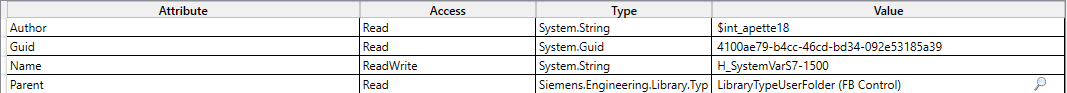

In [ ]:
'''
making a path using a recursive function to get the parent of the item until it has no parent aatribute anymore
'''

def get_parents(item, path=None):
	if path is None:
		path = []

	try:
		parent_Name = item.Parent.GetAttribute('Name')
		path.append(parent_Name)

		if hasattr(item.Parent, 'Parent'):
			get_parents(item.Parent, path)
		
		return path
	except:
		return path

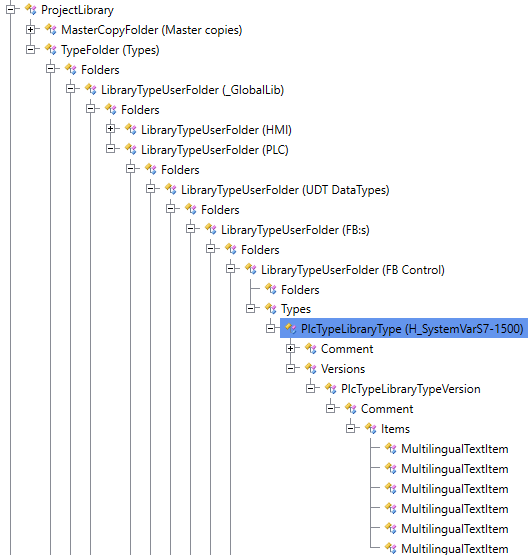

In [ ]:
for type in types:
	parents = get_parents(type)
	path = '/'.join(parent for parent in reversed(parents))
	path = f'{path}/{type.Name}'

	for version in type.Versions:
		instanceInfos = version.FindInstances(plc_software)
		instanceInfo = [instanceInfo.LibraryTypeInstance for instanceInfo in instanceInfos]

		if instanceInfos.Count > 0:
			print(path)
			print('\t', instanceInfos, len(instanceInfo))
			for instance in instanceInfo:
				instance_Name = instance.GetAttribute('Name')
				parents = get_parents(instance)
				path = '/'.join(parent for parent in reversed(parents))
				path = f'{path}/{instance_Name}'

				print('\t\t', instance_Name, instance.GetAttribute('Number'))
				print('\t\t', path)
				

Types/_GlobalLib/PLC/UDT DataTypes/FB:s/FB Control/H_SystemVarS7-1500
	 System.Collections.Generic.IList<Siemens.Engineering.Library.Types.LibraryTypeInstanceInfoList> 1
		 H_SystemVarS7-1500 200
		 P712713A01/P209000AE01-JC5/P209000AE01-JC5/P209000AE01-JC5/P209000AE01-JC5/PLC data types/_GlobalLib/PLC/UDT DataTypes/FB:s/FB Control/H_SystemVarS7-1500
Types/_GlobalLib/PLC/UDT DataTypes/FB:s/FB Supervision/ZMStatus
	 System.Collections.Generic.IList<Siemens.Engineering.Library.Types.LibraryTypeInstanceInfoList> 1
		 ZMStatus 20
		 P712713A01/P209000AE01-JC5/P209000AE01-JC5/P209000AE01-JC5/P209000AE01-JC5/PLC data types/_GlobalLib/PLC/UDT DataTypes/FB:s/FB Supervision/ZMStatus
Types/_GlobalLib/PLC/UDT DataTypes/FB:s/FB Supervision/SupervisionProdModeCmdReq
	 System.Collections.Generic.IList<Siemens.Engineering.Library.Types.LibraryTypeInstanceInfoList> 1
		 SupervisionProdModeCmdReq 48
		 P712713A01/P209000AE01-JC5/P209000AE01-JC5/P209000AE01-JC5/P209000AE01-JC5/PLC data types/_GlobalLib/

user assigns the groups in the project wich consist of library blocks
- get_library_blocks gives all the blocks that are located in these groups
- check_library_connection checks if the retrieved block from get_library_blocks are effectivly connected to the library

In [14]:
def get_library_blocks(plc_list):
	software_library_groups = ["_GlobalLib", "_LocalLibGB", "_LocalLibVCG"] # get input from user in wich groups/maps the library blocks are located
	blocks = {}

	for plc in plc_list:
		blocks[plc] = {}
		software_container = tia.IEngineeringServiceProvider(plc).GetService[hwf.SoftwareContainer]()
		plc_software = software_container.Software
		
		block_groups = [group for group in plc_software.BlockGroup.Groups if group.Name in software_library_groups]

		for group in block_groups:
			blocks_list = get_blocks(group, group_included=False)
			blocks[plc][group] = blocks_list
	return blocks


def check_library_connection(plc_list, myproject):
	lib_blocks = get_library_blocks(plc_list)
	project_name = myproject.Name
	library_df = pd.DataFrame()
	info = {}

	for plc in lib_blocks.keys():
		plc_name = plc.Name

		for software_library_group in lib_blocks[plc]:
			library_group_name = software_library_group.Name
			group_blocks_list = lib_blocks[plc][software_library_group]
			
			for block in group_blocks_list:
				service = tia.Library.Types.LibraryTypeInstanceInfo
				instanceInfo = block.GetService[service]()
				blockType = block.GetType().Name
				blockNumber = block.Number
				folder = block.Parent.GetAttribute("Name")
				block_modifiedDate = block.ModifiedDate
				isConsistent = block.IsConsistent
				libraryConformanceStatus = block.GetAttribute('LibraryConformanceStatus')

				# when the block is connected to the library instanceInfo will return a LibraryTypeInstanceInfo object
				status = True if type(instanceInfo) == service and block_modifiedDate else False

				update_library_df = pd.DataFrame({
					'Project':[project_name], 
					'ModifiedDate':[block_modifiedDate], 
					'PLC':[plc_name], 
					'LibraryFolder':[library_group_name], 
					'Folder':[folder], 'Name':[block.Name], 
					'Type':[blockType], 'Number':[blockNumber], 
					'ConnectedToLibrary':[status],
					'isConsisent':[isConsistent],
					'Version':[instanceInfo.LibraryTypeVersion.VersionNumber if status else 'NaN'],
					'LibraryState':[instanceInfo.LibraryTypeVersion.State if status else 'NaN'],
					'LibraryConformanceStatus':[libraryConformanceStatus]
					})
				
				library_df = pd.concat([library_df, update_library_df], ignore_index=True)

		unconnected_blocks = library_df.loc[library_df['ConnectedToLibrary'] == False].shape[0]
		connected_blocks = library_df.loc[library_df['ConnectedToLibrary'] == True].shape[0]

		info['total'] = unconnected_blocks + connected_blocks
		info['unconnected'] = unconnected_blocks
		info['connected'] = connected_blocks
	return library_df, info

In [15]:
df = check_library_connection(PLC_List, myproject)[0]
print(check_library_connection(PLC_List, myproject)[0].to_string())

print(
    'from the total of', check_library_connection(PLC_List, myproject)[1]['total'], 
    'blocks, there are', check_library_connection(PLC_List, myproject)[1]['unconnected'], 
    'unconnected and', check_library_connection(PLC_List, myproject)[1]['connected'], 'connected to the library'
    )

        Project         ModifiedDate              PLC LibraryFolder            Folder                                       Name Type  Number  ConnectedToLibrary  isConsisent    Version LibraryState                                                                                                                                                                                  LibraryConformanceStatus
0    P712713A01   2/03/2023 14:12:15  P209000AE01-JC5    _GlobalLib       FB Function                                     LTimer   FB    1009                True         True   15.504.0    Committed  Warning: The block contains direct access to inputs, outputs, bit memories, indirect access to the registry or indirect access to external memory areas that are unknown at the time of compilation.\r\n
1    P712713A01   2/03/2023 14:12:14  P209000AE01-JC5    _GlobalLib       FB Function                                   LAcofDet   FB    1416                True         True   15.504.0    Committed

In [63]:
import datetime
test = df['ModifiedDate'].values[0]
print(type(test))
test = datetime.datetime.strptime(test, '%d-%m-%Y %H:%M:%S').strftime('%d-%m-%Y %H:%M:%S')
print(type(test))
print(test)
df['ModifiedDate'] = pd.to_datetime(df['ModifiedDate'], format='%d-%m-%Y %H:%M:%S')
df['ModifiedDate'] = df['ModifiedDate'].dt.strftime('%d-%m-%Y %H:%M:%S')

print(df)

<class 'str'>
<class 'str'>
02-03-2023 14:12:15
        Project         ModifiedDate              PLC LibraryFolder  \
0    P712713A01  02-03-2023 14:12:15  P209000AE01-JC5    _GlobalLib   
1    P712713A01  02-03-2023 14:12:14  P209000AE01-JC5    _GlobalLib   
2    P712713A01  02-03-2023 14:12:15  P209000AE01-JC5    _GlobalLib   
3    P712713A01  02-03-2023 14:12:15  P209000AE01-JC5    _GlobalLib   
4    P712713A01  02-03-2023 14:12:15  P209000AE01-JC5    _GlobalLib   
..          ...                  ...              ...           ...   
316  P712713A01  04-08-2023 14:29:01  P209000AE01-JC5  _LocalLibVCG   
317  P712713A01  04-08-2023 14:31:15  P209000AE01-JC5  _LocalLibVCG   
318  P712713A01  02-03-2023 14:12:35  P209000AE01-JC5  _LocalLibVCG   
319  P712713A01  02-03-2023 14:12:35  P209000AE01-JC5  _LocalLibVCG   
320  P712713A01  31-05-2023 15:02:02  P209000AE01-JC5  _LocalLibVCG   

              Folder                 Name Type  Number  ConnectedToLibrary  \
0        FB Function 

Make dataframe of all block with there parameters
- when DB, add some extra parameters to the dataframe
- also make a list with only the DB's in it
	

In [68]:
import System

date = System.DateTime.Now

block_modifiedDate = datetime.datetime(date.Year, date.Month, date.Day, date.Hour, date.Minute, date.Second, date.Millisecond * 1000)
type(block_modifiedDate)

print(date, block_modifiedDate)


19/08/2024 15:06:57 2024-08-19 15:06:57.088000


In [ ]:
def map_structure(item, groups=None):
	if groups is None:
		groups = []

	try:
		# when the item has no more parent, error will be raised wich will be catched/passed and the function will return the groups
		folder = item.Parent.GetAttribute('Name')
		item = item.Parent
		if folder is not None and folder not in groups:
			groups.append(folder)
			map_structure(item, groups)
	except:
		pass
	return groups

In [ ]:
def get_project_blocks_df(plc_list, myproject, group, folder_path=False):
	blocks = get_blocks(group, group_included=False)
	exepted_types = ['OB', 'FC', 'FB', 'GlobalDB', 'InstanceDB']
	project_name = myproject.Name

	df = pd.DataFrame()
	instance_db = []
	
	for plc in plc_list:
		for block in blocks:
			blockType = block.GetType().Name
			blockNumber = block.Number
			folder = block.Parent.GetAttribute('Name')
			plc_name = plc.Name
			
			if blockType in exepted_types:
				if blockType == 'InstanceDB':
					instance_db.append(block)
					instanceOf = block.InstanceOfName
				else: 
					instanceOf = 'NaN'

				df_update = pd.DataFrame({
					'Project':[project_name], 
					'ModifiedDate':[block.ModifiedDate], 
					'PLC':[plc_name], 
					'Folder':[folder],
					'Name':[block.Name], 
					'Type':[blockType], 
					'Number':[blockNumber],
					'InstanceOf':[instanceOf]
					})
			else:
				raise ValueError('Blocktype not recognised')
			
			if folder_path:
				structure = map_structure(block)
				reversed_structure = reversed(structure)
				path = '/'.join(folder for folder in reversed_structure)
				df_update['Path'] = path
			
			df = pd.concat([df, df_update], ignore_index=True)
	return df, instance_db



def get_lib_connection_used_blocks(PLC_List, myproject, folder_path=False):
	location_projectBlocks = plc_software.BlockGroup
	location_safetyBlocks = plc_software.BlockGroup.SystemBlockGroups[0]

	project_blocks_df, instanceDB_object = get_project_blocks_df(PLC_List, myproject, location_projectBlocks)
	safety_blocks_df, safety_instanceDB_object = get_project_blocks_df(PLC_List, myproject, location_safetyBlocks)
	combined_df = pd.concat([project_blocks_df, safety_blocks_df], ignore_index=True)
	combined = instanceDB_object + safety_instanceDB_object

	instanceDB_data = []
	info = {}

	# get the library blocks to see if the project block is an instance of a library block
	connected_lib_group_blocks_df = check_library_connection(PLC_List, myproject)[0]
	
	for block in combined:
		block_name = block.Name
		isConsistent = block.IsConsistent
		try:
			instanceOfNumber = block.GetAttribute('InstanceOfNumber')
			instanceOfName = block.GetAttribute('InstanceOfName')
		except:
			pass

		search_filter_library = (connected_lib_group_blocks_df['Name'] == instanceOfName) & (connected_lib_group_blocks_df['Number'] == instanceOfNumber)
		search_filter_project = (combined_df['Name'] == block_name) & (combined_df['Type'] == 'InstanceDB')

		project_block_data = combined_df.loc[search_filter_project].copy()

		if not connected_lib_group_blocks_df.loc[search_filter_library].empty:
			project_block_data['InstanceOfNumber'] = instanceOfNumber
			project_block_data['ConnectedToLibrary'] = connected_lib_group_blocks_df.loc[search_filter_library, 'ConnectedToLibrary'].values[0]
			project_block_data['NameInLibrary'] = connected_lib_group_blocks_df.loc[search_filter_library, 'Name'].values[0]
			project_block_data['Version'] = connected_lib_group_blocks_df.loc[search_filter_library, 'Version'].values[0]
			project_block_data['isConsistent'] = isConsistent
			project_block_data['LibraryState'] = connected_lib_group_blocks_df.loc[search_filter_library, 'LibraryState'].values[0]
		
		if folder_path:
			structure = map_structure(block)
			reversed_structure = reversed(structure)
			path = '/'.join(folder for folder in reversed_structure)
			project_block_data['Path'] = path
		
		instanceDB_data.append(project_block_data)

	instanceDB_df = pd.concat(instanceDB_data, ignore_index=True)
	unconnected_blocks = instanceDB_df.loc[instanceDB_df['ConnectedToLibrary'] == False].shape[0]
	connected_blocks = instanceDB_df.loc[instanceDB_df['ConnectedToLibrary'] == True].shape[0]

	info['total'] = unconnected_blocks + connected_blocks
	info['unconnected'] = unconnected_blocks
	info['connected'] = connected_blocks

	return instanceDB_df, info

In [ ]:
print(get_lib_connection_used_blocks(PLC_List, myproject, folder_path=True)[0].to_string())

        Project         ModifiedDate              PLC             Folder                                Name        Type  Number                             InstanceOf  InstanceOfNumber ConnectedToLibrary                   NameInLibrary    Version isConsistent LibraryState                                                                                            Path
0    P712713A01   22/03/2023 9:42:19  P209000AE01-JC5           Instance     _209000NCP01VDMasterAlarmReport  InstanceDB    1021                    LVDComMasterS7-1500            2210.0               True             LVDComMasterS7-1500   15.504.1         True    Committed          P209000AE01-JC5/Program blocks/_PLC209 DB:s/General/ComVD/Alarm Communication/Instance
1    P712713A01   22/03/2023 9:42:14  P209000AE01-JC5           Instance            _209000NCP01AlarmHandler  InstanceDB    1020                              LComAlarm            2105.0               True                       LComAlarm   15.504.0         True

In [ ]:
print(get_project_blocks_df(PLC_List, myproject, plc_software.BlockGroup, folder_path=True)[0].to_string())

        Project         ModifiedDate              PLC                       Folder                                       Name        Type  Number                      InstanceOf                                                                                            Path
0    P712713A01   4/08/2023 14:30:25  P209000AE01-JC5               Program blocks                                    Changes          FC       1                             NaN                                                                  P209000AE01-JC5/Program blocks
1    P712713A01  16/11/2021 16:38:56  P209000AE01-JC5                     PLC OB:s                                   CYC_Proc          OB      34                             NaN                                                         P209000AE01-JC5/Program blocks/PLC OB:s
2    P712713A01   2/04/2021 14:10:22  P209000AE01-JC5                     PLC OB:s                           COMPLETE RESTART          OB     100                             NaN 

In [8]:
def find_block(group, block_name, block_number, search_result=None):
		"""
		Retrieves a software block with the given name.

		Parameters:
		- block_name (str): The name of the software block to retrieve.

		Returns:
		- block: The software block with the given name, or None if not found.
		"""

		try:
			search_result = group.Blocks.Find(block_name)

			if search_result is not None:
				if search_result.Number != block_number:
					raise Exception(f'Block number does not match: {search_result.Number} != {block_number}')
				return search_result 

			for subgroup in group.Groups:
				search_result = find_block(subgroup, block_name, block_number, search_result)
				if search_result is not None:
					return search_result
		except Exception as e:
			print(f'Failed to retrieve software block: {str(e)}')
			
		return search_result

In [ ]:
print(find_block(plc_software.BlockGroup, 'H_SystemVarS7-1500', 610))

None


In [ ]:

import inspect

def print_attributes(item, get = False):
    members = inspect.getmembers(item)
    print(type(item))
    print('Attributes: ')
    for item in members:
        if (item[0][0]!='_') and ((get) or (item[0][:4]!='get_')):
            print(item[0]+'\t\t' + str(item[1])+'\t\t' + str(type(item[1])))
    print('\n')
    pass

In [ ]:
# returns all attributes of an object including failsafe parameters and write the value of the attribute next to it
def attribute_info(item):
    for info in item.GetAttributeInfos():
        print(info.Name, ':\t', item.GetAttribute(info.Name))


In [ ]:
#Closing Project
Init.close_project(myproject, myinterface)

In [2]:
list1 = [
    "209210AS10-JW40", "209000AE02-JW208.X2", "209210AX02-JW43", "209000AK04M1-UE140", "209210AS20-JW48",
    "209220CWP10-JX55", "209210AS11-JW42", "209210CWP10-JX44", "209000AE02-JW208.X1", "ETHERNET",
    "209220AX01-JW51", "PROFINET interface", "211212AE1-JW200", "209210AX01-JW41", "209230AX01-JW61",
    "209000AE01-JC31", "POFIBUS", "209220CWP10-JX57", "209000AK01-JW35", "209230CHB22M14-UE152",
    "209000AK04M4-UE142", "209000AS01-JW38", "209220Field-JW222", "209000AE02-JW210", "209000AE02-JW71",
    "209210CWP20-JX47", "209000AK01E1-BE30", "209230CR22M1-UE153", "209220AS10-JW50", "209000AE02-JW211",
    "209000AK04M4-UE141", "209220AS11-JW52", "209210Field-JW221", "209220CWP10-JX54", "209220AS20-JW58",
    "209000AK03-JW36", "209000AK03M4-UE131", "209230Field-JW223", "209220Field-JW232", "209220CHB21M14-UE144",
    "209230CA21M4-UE150", "209210CWP20-JX46", "209210CHB21M14-UE134", "209000AK03M4-UE132", "209000AE02-JW70",
    "209000AK04M1-UE143", "209000AK03M1-UE130", "209230ASD01-JW190", "209210CWP10-JX45", "PROFINET",
    "209000AK03M1-UE133", "209230AS10-JW60", "209220CWP20-JX56", "209000AK02-JC32", "209210Field-JW231",
    "209220AX02-JW53", "209000AS02-JW39", "209000AK04-JW37", "209230CHB21M14-UE151"
]

# List 2: List to compare against
list2 = [
    "209220AX01-JW51", "209230CA21M4-UE150", "209000AE02-JW208.X1", "209210CHB21M14-UE134", "209210Field-JW221",
    "209000AS02-JW39", "209230Field-JW223", "209000AK02-JC32", "209000AS01-JW38", "209000AK04M4-UE142",
    "209230CHB21M14-UE151", "209230CHB22M14-UE152", "209210AS10-JW40", "ETHERNET", "209230AX01-JW61",
    "209000AE02-JW71", "209000AK03M4-UE132", "209220AS11-JW52", "209220AS10-JW50", "209220CWP10-JX54",
    "209220CHB21M14-UE144", "209000AK03M1-UE133", "209220AS20-JW58", "211212AE1-JW200", "209210CWP10-JX44",
    "209000AK03-JW36", "209220CWP10-JX55", "209000AK04M4-UE141", "POFIBUS", "209210CWP10-JX45",
    "209210AX01-JW41", "209220Field-JW232", "209000AE02-JW210", "209220CWP10-JX57", "209000AK01-JW35",
    "209210CWP20-JX46", "209000AE01-JC31", "209000AK04M1-UE143", "209000AE02-JW70", "209210Field-JW231",
    "209210CWP20-JX47", "209220CWP20-JX56", "209000AK03M4-UE131", "209000AK03M1-UE130", "209000AK04-JW37",
    "209220AX02-JW53", "209230AS10-JW60", "209210AS20-JW48", "209000AK04M1-UE140", "209000AK01E1-BE30",
    "PROFINET", "209000AE02-JW208.X2", "209210AX02-JW43", "209000AE02-JW211", "209220Field-JW222",
    "209210AS11-JW42", "PROFINET interface", "209230CR22M1-UE153", "209230ASD01-JW190"
]

# Convert lists to sets
set1 = set(list1)
set2 = set(list2)

# Find the difference
missing_nodes = set1 - set2

print("Missing node addresses:", missing_nodes)

Missing node addresses: {'209230ASD01-JW190'}


In [6]:
def getDeviceType(attribute):
    """
    Returns the device type and color based on the given device name.

    Parameters:
    - attribute (str): The attribute of the device.

    Returns:
    - device_type (str): The type of the device.
    - color (str): The color associated with the device type.
    """

    types = [
        ('PLC', ['S71500'], 'red'),
        ('module', ['ET200SP', 'ET200ECO'], 'blue'),
        ('scalance', ['Scalance', 'SCALANCE'], 'green'),
        ('drive', ['SIEMENS', 'DFS', 'SEW'], 'yellow'),
        ('PNcoupler', ['PnPnCoupler'], 'orange'),
        ('other', [''], 'gray')
    ]

    for deviceType, identifiers, color in types:
        if any(identifier in attribute for identifier in identifiers):
            return deviceType, color
    return 'other', 'gray'

attr = {'deviceType': 'GSD:GSDML-V2.42-SIEMENS-ET200ECO-20221118.XML/D'}
print(getDeviceType(attr['deviceType']))

('drive', 'yellow')


In [9]:
import os
# Get all the blocks within a group
def get_blocks(group):
    Blocks = [] # list to store all the blocks
    for block in group.Blocks: # all the blocks directly in the folder
        Blocks.append(block) # add them to the list
    for sub_group in group.Groups: # for all the subgroups in the folder
        Blocks.extend(get_blocks(sub_group)) # get all the blocks of the subgroup
    return Blocks # returns the list of all the blocks

Blocks = get_blocks(plc_software.BlockGroup) # all the blocks of the main Block-folder in the plc
print(Blocks)


[<Siemens.Engineering.SW.Blocks.FC object at 0x000002D851555600>, <Siemens.Engineering.SW.Blocks.OB object at 0x000002D8515E7800>, <Siemens.Engineering.SW.Blocks.OB object at 0x000002D8515E7E80>, <Siemens.Engineering.SW.Blocks.OB object at 0x000002D8515E7D40>, <Siemens.Engineering.SW.Blocks.OB object at 0x000002D8515E7FC0>, <Siemens.Engineering.SW.Blocks.OB object at 0x000002D8515E7480>, <Siemens.Engineering.SW.Blocks.OB object at 0x000002D8515E7240>, <Siemens.Engineering.SW.Blocks.OB object at 0x000002D8515E7C00>, <Siemens.Engineering.SW.Blocks.OB object at 0x000002D8515E7940>, <Siemens.Engineering.SW.Blocks.OB object at 0x000002D8515E7040>, <Siemens.Engineering.SW.Blocks.OB object at 0x000002D8515E7BC0>, <Siemens.Engineering.SW.Blocks.OB object at 0x000002D8515E7600>, <Siemens.Engineering.SW.Blocks.OB object at 0x000002D8515E7980>, <Siemens.Engineering.SW.Blocks.OB object at 0x000002D8515E7C80>, <Siemens.Engineering.SW.Blocks.OB object at 0x000002D8515E7880>, <Siemens.Engineering.SW.

In [10]:
from System.IO import FileInfo
# First export all the blocks to a folder
# make sure the folder do exist but is empty
def export_block(block, path=None): # for all the blocks
		print("exporting")
		path = path 
		try: # try to export the block
				block.Export(FileInfo(path), tia.ExportOptions.WithDefaults) 
		except: # one of the raison is that the block needs to be compiled
				print(f'\nError in {type}{block.Number}')
				print('Try to compile Block...')

				result = block.GetService[tia.Compiler.ICompilable]().Compile() # compiling the block
				for message in (result.Messages):
						print((message.Description)) # prit

				try:# if the block is compiled, try to export again
						block.Export(FileInfo(path), tia.ExportOptions.WithDefaults)
						print('solved')
				except: # for some (safety) blocks the block can not be exported
						print('Error not solved\n')

In [11]:
import pprint
import xml.etree.ElementTree as ET
import xmltodict
pp = pprint.PrettyPrinter(indent=1)
block = find_block(plc_software.BlockGroup, 'LSystemVarS7-1500', 2204)
block_type = block.GetType().Name
block_number = str(block.Number)

path = os.path.join(os.getcwd() + f'\\TIA demo exports\\{myproject.Name}\\file\\find programblock\\{block_type}{block_number}.xml')
print(path)
if not os.path.exists(path):
	export_block(block, path)
else:
	print(f'Block {block_type}{block_number} already exported')
tree = ET.parse(path)
xml_date = tree.getroot()
xmlstr = ET.tostring(xml_date, encoding='utf-8', method='xml')
doc = dict(xmltodict.parse(xmlstr))

c:\Users\QBAUWENS\Documents\Openess\docs\TIA demo exports\P712713A01\file\find programblock\FB2204.xml
exporting


In [13]:
pp.pprint(doc)

{'Document': {'@xmlns:ns0': 'http://www.siemens.com/automation/Openness/SW/Interface/v3',
              '@xmlns:ns1': 'http://www.siemens.com/automation/Openness/SW/NetworkSource/FlgNet/v3',
              '@xmlns:ns2': 'http://www.siemens.com/automation/Openness/SW/NetworkSource/StatementList/v3',
              'DocumentInfo': {'Created': '2024-09-11T10:53:03.4856354Z',
                               'ExportSetting': 'WithDefaults',
                               'InstalledProducts': {'OptionPackage': [{'DisplayName': 'TIA '
                                                                                       'Portal '
                                                                                       'Openness',
                                                                        'DisplayVersion': 'V15.1 '
                                                                                          'Update '
                                                                          

In [14]:
def search_part(network, ns, UId, portname=None):
	if UId is None:
		raise ValueError('UId is not given')
	elif network is None:
		raise ValueError('Please provide a network')
	nwk_source = network['AttributeList']['NetworkSource']
	nwk_part = nwk_source[f'ns{ns}:FlgNet'][f'ns{ns}:Parts'][f'ns{ns}:Part']

	if f'ns{ns}:FlgNet' not in nwk_source.keys():
		raise ValueError(f"'ns{ns}:FlgNet' not found in the network source")
	
	print(f"Searching for part with UId {UId} in the network, networkID: '{network['@ID']}'")
	for part in nwk_part:
		part_disabled = part['@DisabledENO']
		part_name = part['@Name']
		part_UId = part['@UId']
		
		if (part_UId == UId):
			print(f"Part with UId '{UId}' found in the network:")
			print(f"\tpart disabled: '{part_disabled}'")
			print(f"\tpart name: '{part_name}'")
			return part
		else:
			raise ValueError(f"No part with UId {UId} found in the network")
	

In [68]:
def search_wire(network, ns, compUId=None, partUId=None, portname=None):
	if compUId is None and partUId is None:
		raise ValueError('Provide either a componentUId or a partUId')
	elif network is None:
		raise ValueError('Please provide a network')
	nwk_source = network['AttributeList']['NetworkSource']

	if f'ns{ns}:FlgNet' not in nwk_source.keys():
		raise ValueError(f"'ns{ns}:FlgNet' not found in the network source")

	nwk_wires = nwk_source[f'ns{ns}:FlgNet'][f'ns{ns}:Wires']
	target_ports = []

	try:
		for i, wire in enumerate(nwk_wires[f'ns{ns}:Wire']):
			if f'ns{ns}:IdentCon' not in wire.keys():
				continue
			comp_UId = wire[f'ns{ns}:IdentCon']['@UId'] # get the source of the wire (value)
			part_port = wire[f'ns{ns}:NameCon']['@Name'] # get the target/port where the wite is connected to
			part_UId = wire[f'ns{ns}:NameCon']['@UId'] # get the target/part that the wire goes to
			# the parameter that contains the libVersion should be connected to the input of the move block
			# and the part is the same
			if partUId and portname:
				condition_met = (part_UId == partUId) and (part_port == portname)
				if condition_met:
					return comp_UId
			elif partUId is None:
				condition_met = (comp_UId == compUId)
				if condition_met:
					print(f"Wire-target part found of wire-source: '{comp_UId}'")
					print(f"\tpartUId: '{part_UId}'")
					print(f"\tpartPort: '{part_port}'")
					return part_UId, part_port
					
			else:
				raise ValueError('The following is allowed (compUId) or (partUID) or (partUID and portname)')
			
	except Exception as e:
		raise ValueError(f"Error in searching for the wire: {str(e)}")
	return target_ports


In [61]:
def search_component(network, ns, UId=None, comp_name=None):
	if UId is None and comp_name is None:
		raise ValueError('Provide either a UId or a component name')

	nwk_source = network['AttributeList']['NetworkSource']
	nwk_id = network['@ID']

	if f'ns{ns}:FlgNet' not in nwk_source.keys():
		return
	
	nwk_parts = nwk_source[f'ns{ns}:FlgNet'][f'ns{ns}:Parts']
	nwk_parts_access = nwk_parts[f'ns{ns}:Access']
	
	try:
		for access in nwk_parts_access:
			if (f"ns{ns}:Symbol" in access.keys()):
				component = access[f"ns{ns}:Symbol"][f"ns{ns}:Component"]
			elif (f"ns{ns}:Constant" in access.keys()):
				component = access[f'ns{ns}:Constant']
			else:
				continue
			component_scope = access[f"@Scope"]
			component_UId = access[f"@UId"]
			
			# always make it a list, even if there is only one component
			if not isinstance(component, list):
				component = [component] 

			# check if a network contains the libVersion
			# system lib version gets set by move block
			for j, component in enumerate(component):
				if f'ns{ns}:Part' not in nwk_parts.keys():
					continue

				if UId is None:
					if component_scope != "LiteralConstant":
						if component['@Name'] != comp_name:
							continue
					else:
						continue
						
				elif comp_name is None:
					if component_UId != UId:
						continue
				else:
					raise ValueError('Provide either a UId or a component name')

				if component_scope == "LiteralConstant":
					print(f"Found component {'with name ' + comp_name if comp_name is not None else 'with UId: ' + UId}")
					print(f"\tnetworkID: '{nwk_id}'")
					print(f"\tcomponentScope: '{component_scope}'")
					print(f"\tcomponentType: '{component[f'ns{ns}:ConstantType']}'")
					print(f"\tcomponentValue: '{component[f'ns{ns}:ConstantValue']}'")
					return access
				else:
					print(f"Found component {'with name ' + comp_name if comp_name is not None else 'with UId: ' + UId}")
					print(f"\tnetworkID: '{nwk_id}'")
					print(f"\tcomponentScope: '{component_scope}'")
					print(f"\tcomponentName: '{component['@Name']}'")
					print(f"\tcomponentID: '{component_UId}'")
					return access
	except Exception as e:
		raise ValueError(f"Error in searching for the component: {str(e)}")
		

In [87]:


FUNC_INTERN_CON  = {
	'move' : {
		'in' : 'out',
		'out' : 'in'
	}
}

def get_para_value(network, ns, UId, portname):
	if UId is None:
		raise ValueError('UId is not given')
	elif network is None:
		raise ValueError('Please provide a network')
	try:
		part = search_part(network, ns, UId)
		part_name = part['@Name'].lower()

		print(f"Getting linked port of function '{part_name}' and port '{portname}': ")
		linked_port = FUNC_INTERN_CON.get(part_name).get(portname)
		if linked_port is None:
			try:
				stripped_portname = re.sub(r'\d+$', '', portname).lower()
				linked_port = FUNC_INTERN_CON.get(part_name).get(stripped_portname)
			except:
				pass
		print(f"\tport: '{portname}'")
		print(f"\tlinked port: '{linked_port}'")
		linked_compUId = search_wire(network, ns, partUId=UId, portname=linked_port)
		print(f"\tlinked component UId: '{linked_compUId}'")
		
		print(f"Searing component (UId: '{linked_compUId}') to retrieve its value")
		linked_comp = search_component(network, ns, UId=linked_compUId)
		linked_compValue = linked_comp[f"ns{ns}:Constant"][f"ns{ns}:ConstantValue"]
		
		return linked_compValue
	except Exception as e:
		raise ValueError(f"Failed to get the value of the parameter: {str(e)}")
	

In [83]:
def get_nwk_para(block_name='', parameter='LVccLibVersion'):
	component_name = parameter
	# genereer doc hier
	if "SW.Blocks.CompileUnit" not in doc["Document"][f"SW.Blocks.FB"]["ObjectList"].keys():
		print("No networks found in block")

	print(f"Scanning namespaces in block '{block_name}':")
	NS = 0
	while True:
			if f'@xmlns:ns{NS}' not in doc['Document'].keys():
					break
			NS += 1

	Network_list = doc['Document']["SW.Blocks.FB"]['ObjectList']['SW.Blocks.CompileUnit']# get the list of all the networks

	print(f"\tTotal namespaces found: '{NS}'")
	print(f"\tTotal networks found: '{len(Network_list)}'")

	print(f"Scanning networks of block '{block_name}' for component/parameter with name: '{component_name}'")
	for i, network in enumerate(Network_list):
		for ns in range(NS):
			try:
				component = search_component(network, ns, comp_name=component_name)
				if component is None:
					continue
				component_UId = component['@UId']

				print(f"Searching wire-target of component '{component_name}' with UId: '{component_UId}'")
				wire_target = search_wire(network, ns, compUId=component_UId)
				if wire_target is None:
					continue
				part_UId, part_port = wire_target
				
				parameter_value = get_para_value(network, ns, part_UId, part_port)
				return parameter_value
			except ValueError as e:
				raise ValueError(f"Error in namespace '{ns}': {str(e)}")

In [88]:
get_nwk_para('LSystemVarS7-1500', 'LVccLibVersion')

Scanning namespaces in block 'LSystemVarS7-1500':
	Total namespaces found: '3'
	Total networks found: '103'
Scanning networks of block 'LSystemVarS7-1500' for component/parameter with name: 'LVccLibVersion'
Found component with name LVccLibVersion
	networkID: '35'
	componentScope: 'GlobalVariable'
	componentName: 'LVccLibVersion'
	componentID: '23'
Searching wire-target of component 'LVccLibVersion' with UId: '23'
Wire-target part found of wire-source: '23'
	partUId: '27'
	partPort: 'out1'
Searching for part with UId 27 in the network, networkID: '35'
Part with UId '27' found in the network:
	part disabled: 'false'
	part name: 'Move'
Getting linked port of function 'move' and port 'out1': 
	port: 'out1'
	linked port: 'in'
	linked component UId: '22'
Searing component (UId: '22') to retrieve its value
Found component with UId: 22
	networkID: '35'
	componentScope: 'LiteralConstant'
	componentType: 'DWord'
	componentValue: '155040'


'155040'

In [12]:
from System import DateTime

# Get the current date and time
date = "2024-08-19 13:00:50"
date2 = "2024-08-19 13:00:49"
date1 = DateTime.Parse(date)
date2 = DateTime.Parse(date2)

date1
date1.CompareTo(date2)

date1.Year

2024